<a href="https://www.kaggle.com/code/erfanhr/notebookfe7cd0ccb7?scriptVersionId=114524178" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
!pip install scanpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 21.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.1/96.1 kB 9.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.5/63.5 kB 4.5 MB/s eta 0:00:00
  Created wheel for session-info: filename=session_info-1.0.0-py3-none-any.whl size=8048 sha256=75f98fa6a3f594ed501a28c579e327b00e6cae79526b439b2ed4b2585b2862b1
  Stored in directory: /root/.cache/pip/wheels/bd/ad/14/6a42359351a18337a8683854cfbba99dd782271f2d1767f87f
Successfully built session-info


In [2]:
# Importing the necessary libraries

import os 

import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Finding the file

os.listdir("/kaggle/input/single-cell-rna-seq-from-stoeckius-et-al-2017")

['GSE100866_CD8_merged-RNA_umi.csv']

In [4]:
# reading the file

adata = sc.read_csv("../input/single-cell-rna-seq-from-stoeckius-et-al-2017/GSE100866_CD8_merged-RNA_umi.csv").T
adata

AnnData object with n_obs × n_vars = 1774 × 11757

# EDA & Data Cleaning

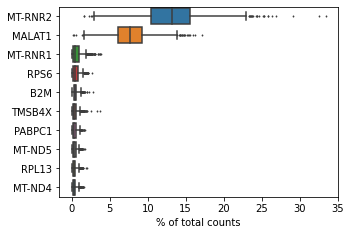

In [5]:
# Top 10 highly expressed genes

sc.pl.highest_expr_genes(adata, n_top = 10)

In [6]:
# 1 - Annotating mitochondrial genes
# 2 - Calculating qc metrics

adata.var["mt"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(adata, qc_vars = ["mt"],
                          percent_top = None, log1p = False,
                          inplace = True)

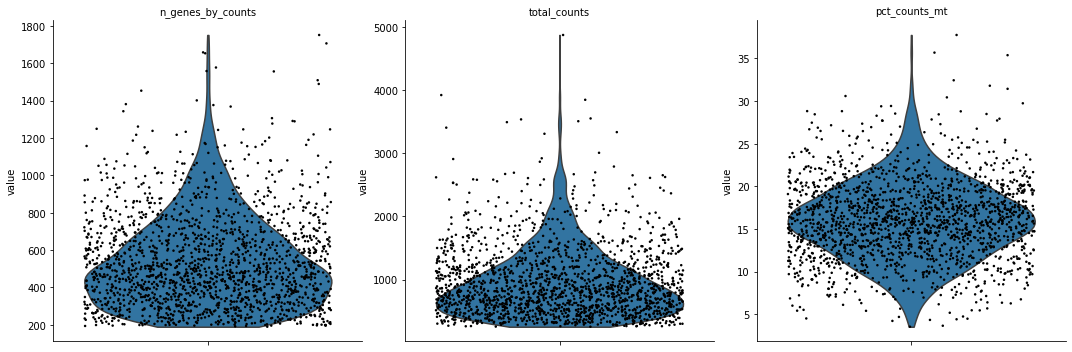

In [7]:
sc.pl.violin(adata, ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
             jitter = 0.4, multi_panel = True, size = 2.5,
            ylabel = "Value", show = True)

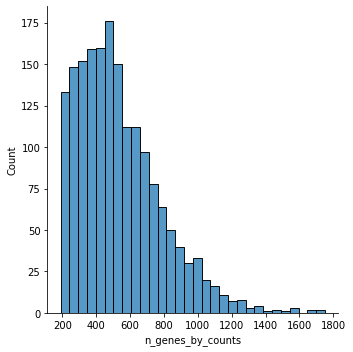

In [8]:
sns.displot(adata.obs["n_genes_by_counts"])
plt.show()

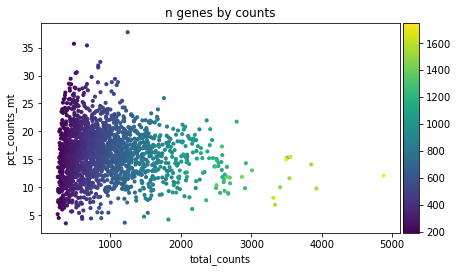

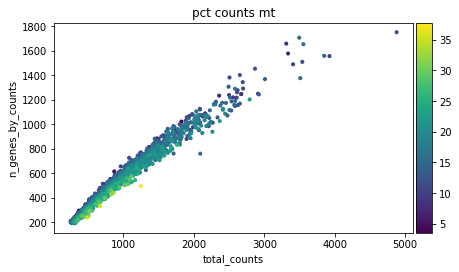

In [9]:
# Detecting outliers 

sc.pl.scatter(adata, x = "total_counts", y = "pct_counts_mt",
             color = "n_genes_by_counts")

sc.pl.scatter(adata, x = "total_counts", y = "n_genes_by_counts", 
              color = "pct_counts_mt")

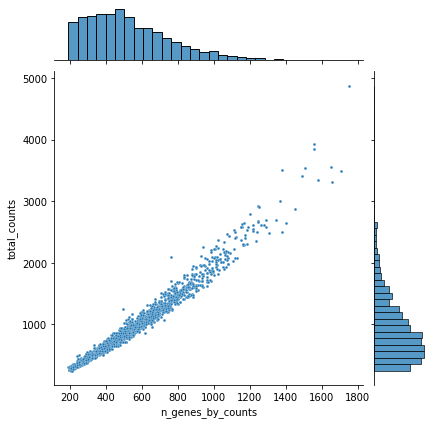

In [10]:
sns.jointplot(
    x = "n_genes_by_counts",
    y = "total_counts",
    data = adata.obs,
    kind = "scatter",
    s = 8
)
plt.show()

In [11]:
sc.pp.filter_cells(adata, min_genes = 200)
sc.pp.filter_genes(adata, min_cells = 3)

In [12]:
# Removing outliers 

bdata = adata
bdata = bdata[bdata.obs.n_genes_by_counts < 1400, :]
bdata = bdata[bdata.obs.pct_counts_mt < 30, :]

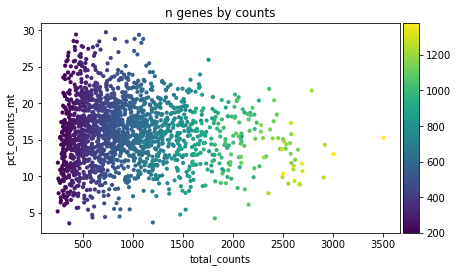

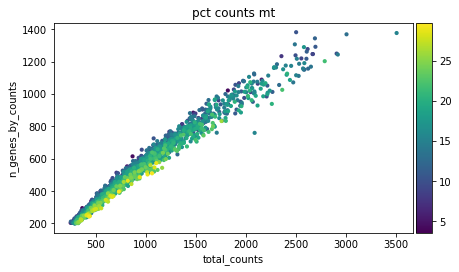

In [13]:
# Visualizinng the normal data

sc.pl.scatter(bdata, x = "total_counts", y = "pct_counts_mt",
             color = "n_genes_by_counts")

sc.pl.scatter(bdata, x = "total_counts", y = "n_genes_by_counts", 
              color = "pct_counts_mt")

# Clustering Analysis

In [14]:
!pip install kneed

In [15]:
# Importing necessary libraries

from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import DistanceMetric
from sklearn.decomposition import PCA
from kneed import KneeLocator as kl

#### 1 - Normalization

In [16]:
norm_data = bdata.copy()

# Normalize counts to 10000 reads per cell
sc.pp.normalize_total(norm_data, target_sum = 1e4)
sc.pp.log1p(norm_data)

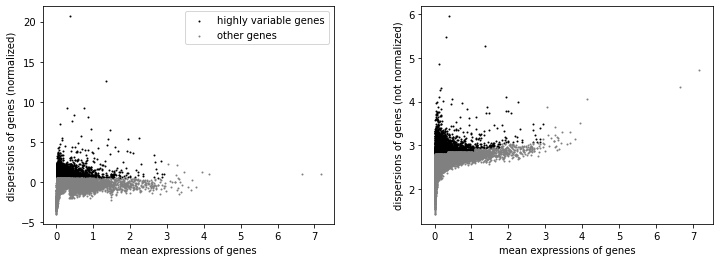

In [17]:
# Identify highly variable genes
# Parameters are arbitrary

sc.pp.highly_variable_genes(norm_data, min_mean = 0.0125,
                           max_mean = 3,
                           min_disp = 0.5)
sc.pl.highly_variable_genes(norm_data)

#### 2 - Clustering 

In [18]:
HVG_data = norm_data.copy()
HVG_data.raw = HVG_data
HVG_data = HVG_data[:, HVG_data.var.highly_variable]

In [19]:
# Scaling to unit variance for PCA

pcHVG_data = HVG_data.copy()
sc.pp.scale(pcHVG_data, max_value = 10)

In [20]:
# Fitting and saving

sc.tl.pca(pcHVG_data, svd_solver = "arpack")
pcHVG_data.write("PCAresult.gzip")

In [21]:
pcHVG_data

AnnData object with n_obs × n_vars = 1738 × 3045
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

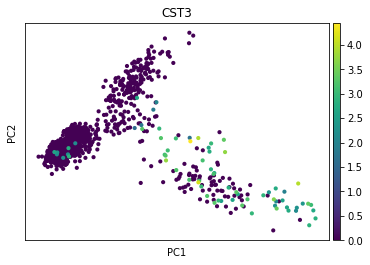

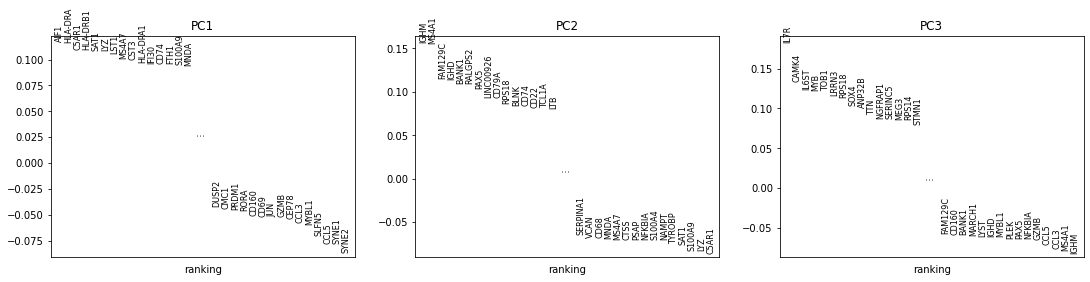

In [22]:
# Visualizing the result

sc.pl.pca(pcHVG_data, color = "CST3")
sc.pl.pca_loadings(pcHVG_data)

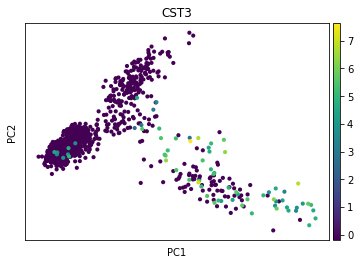

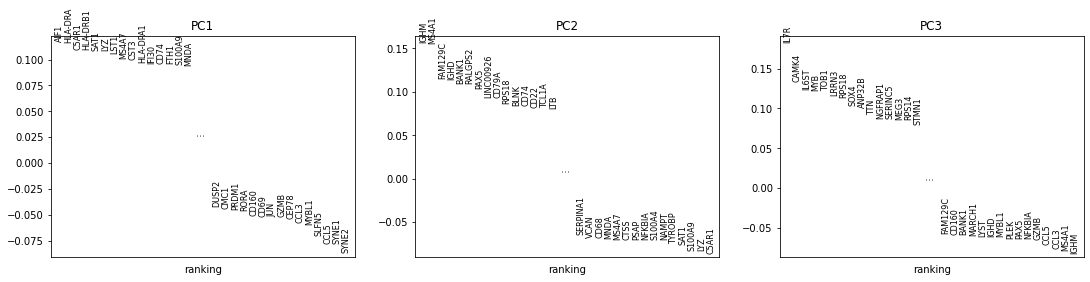

In [23]:
sc.pp.scale(norm_data, max_value = 10)
sc.tl.pca(norm_data, svd_solver = "arpack")
sc.pl.pca(norm_data, color = "CST3")
sc.pl.pca_loadings(norm_data)

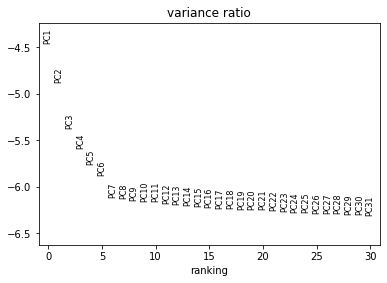

In [24]:
# Visualize the scree plot for PCA 

sc.pl.pca_variance_ratio(pcHVG_data, log = True)

In [25]:
def PCA_Elbow_fit(data):
    model = PCA().fit(data)
    explained_variance = model.explained_variance_ratio_
    pcs = list(range(1, explained_variance.shape[0] + 1))
    klm = kl(pcs, explained_variance, S = 1.0, 
             curve = "convex", direction = "decreasing")
    pcs_used = klm.knee
    pc_list = list(range(1, pcs_used + 1))
    new_data = PCA(n_components = pcs_used, svd_solver = "arpack").fit_transform(data)
    return pcs_used, new_data, pcs, explained_variance, pc_list

In [26]:
label = "HVG_data"
new_frame = pd.DataFrame(HVG_data.X.toarray(), index = HVG_data.obs_names,
                        columns = HVG_data.var_names)
pandas_data = new_frame.values

In [27]:
# Calculating the optimal number of PC by utiliizing PCA_Elbow_fit function

dim, new_matrix, pc_ax, pc_ay, col_labels = PCA_Elbow_fit(pandas_data)
print(dim)

66


In [28]:
columns = ["PC_" + str(i) for i in col_labels]
output_path = "PCA_" + label + str(dim) + ".csv"
PC_frame = pd.DataFrame(new_matrix, index = new_frame.index.values.tolist(),
                       columns = columns)
print(PC_frame.head())
print(PC_frame.shape)

                           PC_1       PC_2      PC_3      PC_4      PC_5  \
CD8_off_CCTGCATATCTT   6.081264   0.936059 -0.154088  2.851775 -1.439859   
CD8_off_CCAAGATTGTGA   5.748081  -2.636669  0.686085  2.289237 -1.275098   
CD8_off_CTCCGGACAACC   6.103024  -1.809931  0.238875 -0.047209 -1.467112   
CD8_off_CCACTTCCCTCT  11.863374  11.374789  2.871875  2.297678 -0.597338   
CD8_off_ACAATCCCGTGG   6.173274  -1.544454  2.333848  4.397098 -3.206944   

                          PC_6      PC_7      PC_8      PC_9     PC_10  ...  \
CD8_off_CCTGCATATCTT  2.519428 -4.398508  0.679436 -0.342306  1.993802  ...   
CD8_off_CCAAGATTGTGA  3.793400 -2.715477  1.099726 -0.227340  1.100182  ...   
CD8_off_CTCCGGACAACC  3.062916 -0.143810  2.093911 -3.191935  2.511943  ...   
CD8_off_CCACTTCCCTCT  3.304740  3.940866 -3.239817  2.028524 -0.466546  ...   
CD8_off_ACAATCCCGTGG  6.116797 -4.085471  1.680341  2.362839  2.566226  ...   

                         PC_57     PC_58     PC_59     PC_60     PC_